In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Mecab,Okt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

In [30]:
# 데이터 불러오기
data = pd.read_csv('./data/train.csv')
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [31]:
# class 열을 숫자로 변환
encoder = LabelEncoder()
data['class'] = encoder.fit_transform(data['class'])

In [32]:
# konlpy의 Mecab을 이용한 토큰화
mecab = Okt()
data['conversation'] = data['conversation'].apply(mecab.morphs)

In [33]:
data.head()

,idx,class,conversation
0,0,3,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, ?, \..."
1,1,3,"[길동, 경찰서, 입니다, ., \n, 9시, 40분, 마트, 에, 폭발물, 을, ..."
2,2,1,"[너, 되게, 귀여운거, 알, 지, ?, 나, 보다, 작은, 남자, 는, 첨, 봤어..."
3,3,0,"[어이, 거기, \n, 예, ??, \n, 너, 말, 이야, 너, ., 이리, 오라..."
4,4,0,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, ?, 저희, 회사, 에서, 이,..."


In [34]:
# 케라스를 이용한 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['conversation'])

sequences = tokenizer.texts_to_sequences(data['conversation'])

In [35]:
# 입력 데이터 패딩 처리
data_pad = pad_sequences(sequences)

In [36]:
type(data_pad)

numpy.ndarray

### Word2Vec

In [37]:

from gensim.models import Word2Vec
tokenized = data_pad

# Set the size of the word vectors
vector_size = 100

model = Word2Vec(tokenized, vector_size, window=5, min_count=3, sg=0)  
#model = Word2Vec(tokenized, vector_size, window=5, min_count=3, sg=0)
#model.wv.most_similar(positive=['영화'])


TypeError: Both corpus_file and corpus_iterable must not be provided at the same time

In [8]:
# 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(data_pad, data['class'], test_size=0.1, random_state=42)

In [9]:
def get_mlp():
    # MLP 모델 생성
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))
    return model

In [10]:
from keras.layers import Conv1D, GlobalMaxPooling1D

def get_cnn():
    # CNN 모델 생성
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [11]:
from keras.layers import LSTM, Dropout

def get_lstm():
    # LSTM 모델 생성
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [12]:
model = get_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 359, 128)          3508480   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,562,308
Trainable params: 3,562,308
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
112/112 [==============================] - 4s 20ms/step - loss: 1.1640 - accuracy: 0.4684 - val_loss: 0.6673 - val_accuracy: 0.7291
Epoch 2/50
112/112 [==============================] - 2s 20ms/step - loss: 0.5315 - accuracy: 0.7781 - val_loss: 0.6064 - val_accuracy: 0.7924
Epoch 3/50
112/112 [==============================] - 2s 18ms/step - loss: 0.1874 - accuracy: 0.9437 - val_loss: 0.5007 - val_accuracy: 0.8329
Epoch 4/50
112/112 [==============================] - 2s 18ms/step - loss: 0.0538 - accuracy: 0.9851 - val_loss: 0.5435 - val_accuracy: 0.8253
Epoch 5/50
112/112 [==============================] - 2s 18ms/step - loss: 0.0432 - accuracy: 0.9871 - val_loss: 0.5656 - val_accuracy: 0.8101
Epoch 6/50
112/112 [==============================] - 2s 17ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.5891 - val_accuracy: 0.8405
Epoch 7/50
112/112 [==============================] - 2s 16ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.6933 - val_accuracy: 0.8456

In [15]:
def train(get_model):
    model = get_model()
    model.summary()
    # 모델 컴파일
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # 모델 학습
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
    return model, history

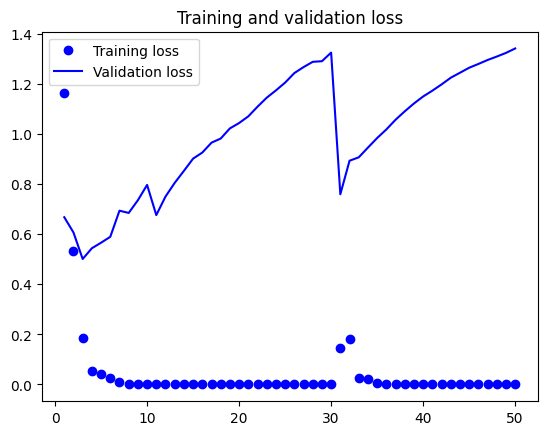

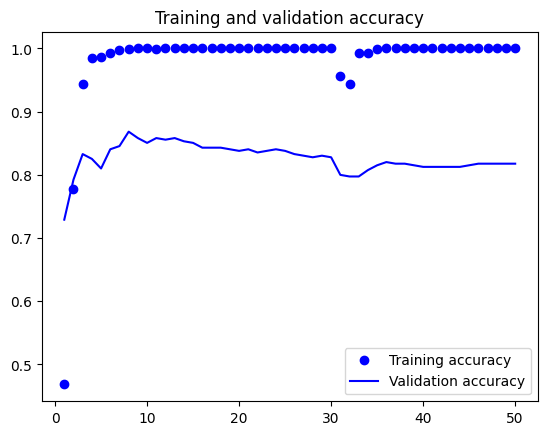

In [16]:
import matplotlib.pyplot as plt

def visualization(history):
    # 시각화를 위한 데이터 정의
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # 손실값 시각화
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 정확도 시각화
    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

visualization(history)


In [17]:
test_x = '''우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?
네? 제가요?
그렇지? 2달만 파견 잘 갔다오면 승진이야.
네? 저는 별로 가고 싶지 않습니다.
여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지
정말 죄송합니다. 저는 못갑니다.
장난해? 모두를 위해 영지씨가 희생하는게 싫어?
네. 부당한 방법으로 가는 것 같습니다.
영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데.
그래도 이 방법은 아닌 것 같습니다. 죄송합니다.'''

test_y = encoder.transform(["직장 내 괴롭힘 대화"])

In [18]:
test_data = {
    "class": [test_y, ],
    "conversation": [test_x, ],
}

df2 = pd.DataFrame(test_data, index=[0])




In [19]:
# 테스트 데이터 전처리
df2['conversation'] = df2['conversation'].apply(mecab.morphs)
test_sequences = tokenizer.texts_to_sequences(df2['conversation'])
test_pad = pad_sequences(test_sequences, maxlen=data_pad.shape[1])

# 예측 수행
predictions = model.predict(test_pad)


1/1 [==============================] - 0s 172ms/step


In [20]:
predicted_classes = np.argmax(predictions, axis=1)

In [21]:
predicted_labels = encoder.inverse_transform(predicted_classes)

In [22]:
predicted_labels

array(['직장 내 괴롭힘 대화'], dtype=object)

In [23]:
def test_routine(model):
    predictions = model.predict(test_pad)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = encoder.inverse_transform(predicted_classes)
    print(predicted_labels)



In [26]:
def one_shot(get_model):
    model, history = train(get_model)
    visualization(history)
    test_routine(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 359, 128)          3508480   
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 128)          82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,599,044
Trainable params: 3,599,044
Non-trainable params: 0
____________________________________________

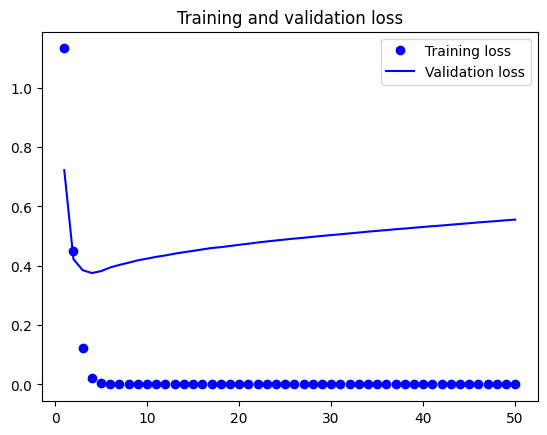

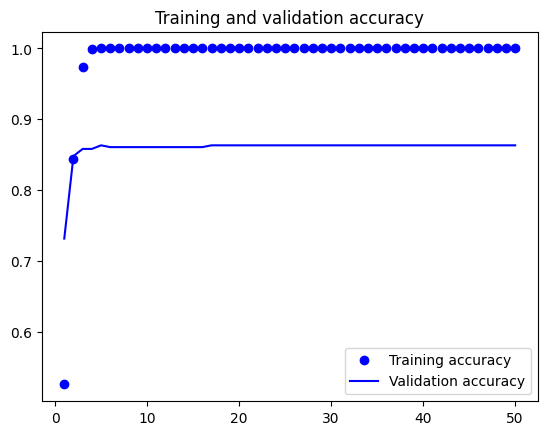

1/1 [==============================] - 0s 41ms/step
['직장 내 괴롭힘 대화']


In [27]:
one_shot(get_cnn)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 359, 128)          3508480   
                                                                 
 flatten (Flatten)           (None, 45952)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2940992   
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,449,732
Trainable params: 6,449,732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
112/112 [==============================] - 1s 4ms/step - loss: 1.3385 - accuracy: 0.3629 - val_loss: 1.1006 - val_accuracy: 0.5873
Epoch 2/50
112/112 [==============

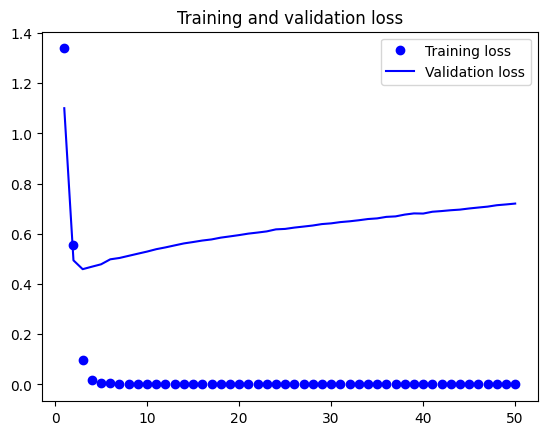

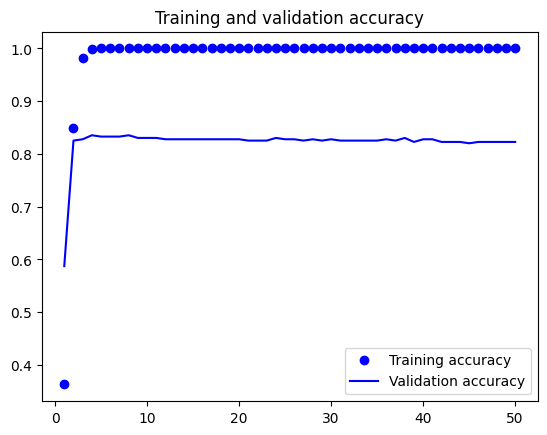

1/1 [==============================] - 0s 25ms/step
['직장 내 괴롭힘 대화']


In [28]:
one_shot(get_mlp)